In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


## Проект 4

Задача данного проекта - построить модель предсказания дефолта клиентов банка на основе линейной классификации.

In [81]:
import pandas as pd
import numpy as np

import seaborn as sns
import pandas_profiling
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [3]:
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
test = pd.read_csv('../input/sf-dst-scoring/test.csv')
sample = pd.read_csv('../input/sf-dst-scoring/sample_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
sample.sample(5)

,client_id,default
1966,65815,0.370193
8518,95989,0.913193
20328,91308,0.624217
4771,49786,0.112040
4562,93678,0.737223


Данные представлены в виде двух датасетов - train и test. Они отличаются наличием колонки default - в test она отсутствует, ее необходимио предсказать.

Объединим датасеты:

In [7]:
df = pd.concat([train, test])

## Предобработка данных

Для исследования данных используем pandas_profiling

In [8]:
pandas_profiling.ProfileReport(df)

В соответствии с отчетом, высокое количество пропусков есть в default (отутствует в данных test).

Проверим остальные пропуски:

In [9]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
dtype: int64

Пропуски расположены в столбце education. Заполним их позднее.

Далее необходимо обработать переменные и перевести в удобный вид для обучения. В целом, признаки можно будет разделить на следующие типы:
 - Категориальные;
 - Бинарные;
 - Численные;

In [10]:
# Для обработки и визуализации признаков напишем функции:

def bin_cat(column):
    # визуализация признака и его связи с дефолтом по кредиту
    px.pie(df, names=column, title='Распределение признака', color=column).show()
    px.histogram(df, x=column, title='Распределение признака', color=column).show()
    # px.histogram(df, x="default", color=column, barmode='group', title='Связь с целевой переменной').show()
    px.histogram(df, x="education", y='default', color=column, 
                title='Связь с целевой переменной').show()
    return 0


def numer(column):
    # визуализация распределения признака, его логарифмированной версии
    # а также их связи с дефолтом
    px.histogram(df, x=column, title='Распределение признака').show()
    px.box(df, y=column, title='Распределение признака').show()
    px.box(df, x='default', y=column, title='Связь с целевой переменной').show()
    
    px.histogram(df, x=np.log(column+1), title='Распределение логарифмированного признака').show()
    px.box(df, y=np.log(column+1), title='Распределение логарифмированного признака').show()
    px.box(df, x='default', y=np.log(column+1), title='Связь log с целевой переменной').show()
    return 0

Также разделим все столбцы на группы для облегчения последующей работы с ними:

In [11]:
# численные
num_cols = []

# бинарные
bin_cols = []

# категориальные
cat_cols = []

## client_id - идентификатор клиента

Содержит только уникальные значения. Не подходит для обучения

## education - уровень образования

Это категориальный признак.

Для заполнения пропусков можно использовать различные подходы. Можно поместить в пропуски специальные значения "неизвестно", можно использовать для заполнения моду, предварительно создав дополнительный столбец, в котором будет отмечено отсутствие или наличие в данном месте пропуска:

Первый вариант:

In [12]:
df.education.fillna('UnknownEdu', inplace = True)

Второй вариант:

In [13]:
# df['education_isnan'] = pd.isna(df['education']).astype('uint8')

In [14]:
# df.education = df.education.fillna(df.education.mode()[0])

In [15]:
cat_cols.append('education')

Посмотрим на распределение:

In [16]:
bin_cat(df.education)

## sex - пол заемщика

Бинарная переменная. Посмотрим на нее:

In [17]:
bin_cols.append('sex')

In [18]:
bin_cat(df.sex)

## age - возраст заемщика

Численная переменная. Рассмотрим её:

In [19]:
num_cols.append('age')

In [20]:
numer(df.age)

## car - флаг наличия автомобиля

Бинарная переменная. Рассмотрм её:

In [21]:
bin_cols.append('car')

In [22]:
bin_cat(df.car)

## car_type - флаг автомобиля иномарки

Бинарная переменная. Рассмотрим её:

In [23]:
bin_cols.append('car_type')

In [24]:
bin_cat(df.car_type)

## decline_app_cnt - количество отказанных прошлых заявок

Числовая переменная, однако ProfileReport показывает высокую сконцентрированность значений около 0. Рассмотрим признак повнимательнее:

In [25]:
num_cols.append('decline_app_cnt')

In [26]:
px.histogram(df, x='decline_app_cnt').show()
px.box(df, y='decline_app_cnt').show()

Основная масса значений признака сконцентрирована около 0. Также boxplot показывает высокое количество выбросов.

Было бы разумно преобразовать признак в категориальный, со значениями "0", "1", "2", "3", "4 и выше"

In [27]:
df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: x if x<4 else 4)

Присоединим его в список категориальных:

In [28]:
cat_cols.append('decline_app_cnt')

## good_work - флаг наличия “хорошей” работы

Бинарная переменная. Рассмотрим её:

In [29]:
bin_cols.append('good_work')

In [30]:
bin_cat(df.good_work)

## bki_request_cnt - количество запросов в БКИ

Числовая переменная. Рассмотрим её:

In [31]:
num_cols.append('bki_request_cnt')

In [32]:
numer(df.bki_request_cnt)

## home_address - категоризатор домашнего адреса

Категориальная переменная. Рассмотрим её:

In [33]:
cat_cols.append('home_address')

In [34]:
bin_cat(df.home_address)

## work_address - категоризатор рабочего адреса

Категориальная переменная. Рассмотрим её:

In [35]:
cat_cols.append('work_address')

In [36]:
bin_cat(df.work_address)

## income - доход заемщика

Числовая переменная. Рассмотрим её:

In [37]:
num_cols.append('income')

In [38]:
numer(df.income)

## foreign_passport - наличие загранпаспорта

Бинарная переменная. Рассмотрим её:

In [39]:
bin_cols.append('foreign_passport')

In [40]:
bin_cat(df.foreign_passport)

## sna - связь заемщика с клиентами банка

In [41]:
cat_cols.append('sna')

In [42]:
bin_cat(df.sna)

## first_time - давность наличия информации о заемщике

Категориальная переменная. Рассмотрим её:

In [43]:
cat_cols.append('first_time')

In [44]:
bin_cat(df.first_time)

## score_bki - скоринговый балл по данным из БКИ

Числовая переменная. Рассмотрим её:

In [45]:
num_cols.append('score_bki')

In [46]:
px.histogram(df, x=df.score_bki, title='Распределение признака').show()
px.box(df, y=df.score_bki, title='Распределение признака').show()
px.box(df, x='default', y=df.score_bki, title='Связь с целевой переменной').show()

## region_rating - рейтинг региона

Числовая переменная, однако имеет всего несколько значений. Удобнее рассматривать ее как категориальную:

In [47]:
cat_cols.append('region_rating')

In [48]:
bin_cat(df.region_rating)

## app_date - дата подачи заявки

In [49]:
df.app_date.sample(5)

56714    17APR2014
10868    21JAN2014
12828    15FEB2014
869      05FEB2014
51480    13JAN2014
Name: app_date, dtype: object

В текущем виде невозможно использовать. Извлечем данные о месяцах, годах и днях подачи заявлений

In [50]:
df['date'] = pd.to_datetime(df.app_date)

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [51]:
df.date.sample(20)

20227   2014-03-22
72642   2014-01-06
29300   2014-03-11
3864    2014-03-21
31279   2014-01-07
18028   2014-03-16
19160   2014-01-18
53325   2014-03-18
19243   2014-01-26
3975    2014-03-15
37664   2014-04-27
10740   2014-03-23
12380   2014-03-14
18687   2014-02-10
8299    2014-01-12
58442   2014-04-01
42005   2014-03-19
72835   2014-03-01
32498   2014-03-10
57244   2014-04-24
Name: date, dtype: datetime64[ns]

In [52]:
df[['day', 'month', 'year']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   day     110148 non-null  int64
 1   month   110148 non-null  int64
 2   year    110148 non-null  int64
dtypes: int64(3)
memory usage: 3.4 MB


In [53]:
px.histogram(df, x=df.day, color='day')

In [54]:
px.histogram(df, x=df.month, color='month')

Представлены данные только за январь-апрель

In [55]:
px.histogram(df, x=df.year, color='year')

Представлены данные только за 2014 год. Нет смысла оставлять данный признак.

In [56]:
df.drop(['year', 'app_date', 'date'], axis=1, inplace=True)

In [57]:
num_cols.append('day')
num_cols.append('month')

## default - флаг дефолта по кредиту

In [58]:
px.pie(df, names=df.default, title='Распределение признака').show()
px.histogram(df, x=df.default, title='Распределение признака').show()

Высокое количество NaN из данных test

## Оценка корреляции

In [60]:
px.imshow(df[num_cols+['default']].corr().abs())

Высоких значений корреляции между признаками не выявлено, что хорошо.

Оценим значимость:

<AxesSubplot:>

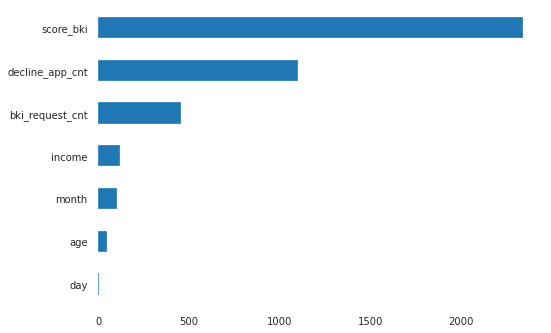

In [61]:
imp_num = pd.Series(f_classif(df[df.default.isna() == False][num_cols], df[df.default.isna() == False]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)

imp_num.plot(kind = 'barh')

Наибольшее значение среди признаков имеет score_bki, куда меньшее decline_app_count, еще меньше region_rating и bki_request_count

Проведем нормализацию численных признаков:

In [62]:
X_num = StandardScaler().fit_transform(df[num_cols].values)
df.loc[:, num_cols] = X_num

In [63]:
# Проверим
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,day,month
0,25905,SCH,M,1.975219,Y,Y,-0.381994,0,-0.208688,-0.443335,50,1,2,-0.506892,4,1,N,0.0,-1.739748,-0.491973
1,63161,SCH,F,1.714757,N,N,-0.381994,0,0.745419,0.438921,50,2,3,-0.484865,4,1,N,0.0,-0.460445,0.427419
2,25887,SCH,M,-1.237142,Y,N,2.560480,0,0.993988,-0.443335,80,1,2,-0.242572,1,4,Y,0.0,-1.739748,-0.491973
3,16222,SCH,F,1.193834,N,N,-0.381994,0,-0.306243,-0.002207,50,2,3,-0.683105,1,3,N,0.0,0.818859,-1.411365
4,101655,GRD,M,0.759731,N,N,-0.381994,1,1.321223,-0.443335,60,2,3,-0.242572,1,4,Y,0.0,0.237357,1.346811


## Обработка бинарных признаков

Закодируем их с помощью LabelEncoder:

In [64]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,day,month
0,25905,SCH,1,1.975219,1,1,-0.381994,0,-0.208688,-0.443335,50,1,2,-0.506892,4,1,0,0.0,-1.739748,-0.491973
1,63161,SCH,0,1.714757,0,0,-0.381994,0,0.745419,0.438921,50,2,3,-0.484865,4,1,0,0.0,-0.460445,0.427419
2,25887,SCH,1,-1.237142,1,0,2.560480,0,0.993988,-0.443335,80,1,2,-0.242572,1,4,1,0.0,-1.739748,-0.491973
3,16222,SCH,0,1.193834,0,0,-0.381994,0,-0.306243,-0.002207,50,2,3,-0.683105,1,3,0,0.0,0.818859,-1.411365
4,101655,GRD,1,0.759731,0,0,-0.381994,1,1.321223,-0.443335,60,2,3,-0.242572,1,4,1,0.0,0.237357,1.346811


Оценим значимость бинарных признаков:

<AxesSubplot:>

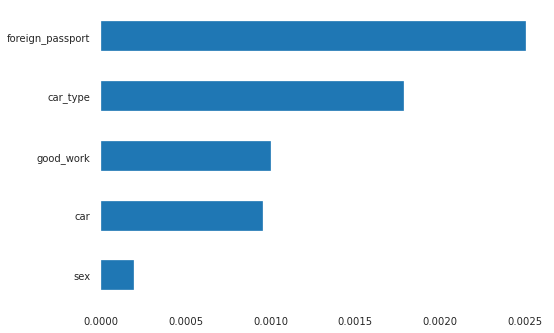

In [65]:
imp_cat = pd.Series(mutual_info_classif(df[df.default.isna() == False][bin_cols], df[df.default.isna() == False]['default'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наибольшее значение имеют foreign_passport и car_type

## Обработка категориальных признаков

Преобразуем значения в цифры с помощью LabelEncoder:

In [66]:
for i in cat_cols:
    label_encoder.fit(df[i])
    df[i] = label_encoder.transform(df[i])

In [67]:
# проверим
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,day,month
0,25905,3,1,1.975219,1,1,0,0,-0.208688,-0.443335,3,0,1,-0.506892,3,0,0,0.0,-1.739748,-0.491973
1,63161,3,0,1.714757,0,0,0,0,0.745419,0.438921,3,1,2,-0.484865,3,0,0,0.0,-0.460445,0.427419
2,25887,3,1,-1.237142,1,0,2,0,0.993988,-0.443335,6,0,1,-0.242572,0,3,1,0.0,-1.739748,-0.491973
3,16222,3,0,1.193834,0,0,0,0,-0.306243,-0.002207,3,1,2,-0.683105,0,2,0,0.0,0.818859,-1.411365
4,101655,1,1,0.759731,0,0,0,1,1.321223,-0.443335,4,1,2,-0.242572,0,3,1,0.0,0.237357,1.346811


Оценим значимость категориальных переменных:

<AxesSubplot:>

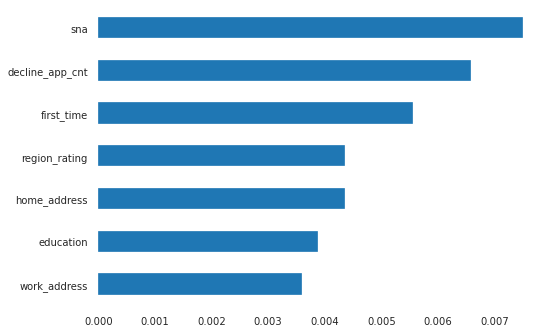

In [68]:
imp_cat = pd.Series(mutual_info_classif(df[df.default.isna() == False][cat_cols], df[df.default.isna() == False]['default'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [69]:
df = pd.get_dummies(df, columns=cat_cols)

In [70]:
df.head()

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,first_time_1,first_time_2,first_time_3,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,region_rating_5,region_rating_6
0,25905,1,1.975219,1,1,0,-0.208688,-0.443335,-0.506892,0,...,0,0,0,0,0,0,1,0,0,0
1,63161,0,1.714757,0,0,0,0.745419,0.438921,-0.484865,0,...,0,0,0,0,0,0,1,0,0,0
2,25887,1,-1.237142,1,0,0,0.993988,-0.443335,-0.242572,1,...,0,0,1,0,0,0,0,0,0,1
3,16222,0,1.193834,0,0,0,-0.306243,-0.002207,-0.683105,0,...,0,1,0,0,0,0,1,0,0,0
4,101655,1,0.759731,0,0,1,1.321223,-0.443335,-0.242572,1,...,0,0,1,0,0,0,0,1,0,0


In [71]:
#cat_cols.append('education')
#cat_cols.append('sex')
#num_cols.append('age')
#bin_cols.append('car')
#bin_cols.append('car_type')
#num_cols.append('decline_app_cnt')
#bin_cols.append('good_work')
#num_cols.append('bki_request_cnt')
#cat_cols.append('home_address')
#cat_cols.append('work_address')
#num_cols.append('income')
#bin_cols.append('foreign_passport')
#cat_cols.append('first_time')
#num_cols.append('score_bki')
#num_cols.append('region_rating')
#num_cols.append('day')
#num_cols.append('month')

## Подготовка и обучение

Вновь разделим данные на тренировочную и тестовую часть:

In [72]:
df_test = df[df.default.isna() == True]
df_train = df[df.default.isna() == False]

In [73]:
px.pie(df_train, names='default')

Значительно преобладает один из классов, и скорее всего стандартные настройки логистической регрессии плохо подойдут. Будем использовать метрики confusion_matrix, f1_score и roc_auc (метрика Accuracy в данном случае мало применима).

Напишем функции для вывода всех метрик и построения кривой:

In [77]:
def count_metrics(y_test, y_pred, probs): 
    
    metrics = {}
    
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, probs)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    
    return metrics

def show_roc_auc(y_test, y_probs):
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    
    plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,Стандартные настройки
f1,0.041494
roc_auc,0.742942
confusion,"[[12872, 61], [1787, 40]]"


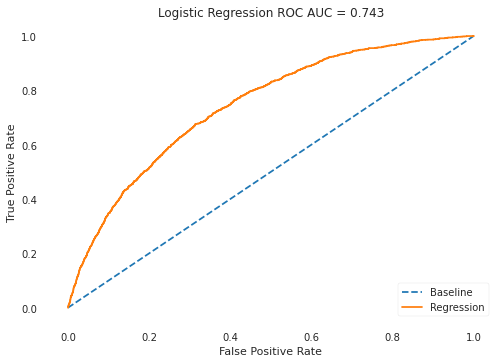

In [82]:
# разделяем данные на X и Y

X = df_train.drop(['client_id','default'], axis=1).values
Y = df_train['default'].values

# выделяем обучающую и валидационную часть

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

# производим обучение

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

y_pred = model_1.predict(X_val)
probs = model_1.predict_proba(X_val)[:,1]

# оценим результаты обучения

metrics_1 = count_metrics(y_val, y_pred, probs)
data_metrics = pd.DataFrame.from_dict(metrics_1, orient='index',columns = ['Стандартные настройки'])

display(data_metrics)
show_roc_auc(y_val, probs)

Были достигнуты хорошие показатели ROC AUC, но метрика F1 имеет низкое значение, а confusion_matrix показывает высокое количество ложно отрицательных значений, что происходит из-за неравного количества дефолтных и не дефолтных клиентов.

Задействуем undersampling - уравняем количество дефолтных и недефолтных клиентов путем отбрасывания части последних:

In [88]:
# находим, представителей какого класса меньше, отделяем их и создаем
# список остальных классов ровно такой же длины
classes = df_train.default.value_counts(ascending=True)

minor = df_train[df_train.default == classes.index[0]]
other = df_train[df_train.default.isin(classes.index[1:])][:len(minor)]

,Стандартные настройки,Undersampling
f1,0.041494,0.681213
roc_auc,0.742942,0.741379
confusion,"[[12872, 61], [1787, 40]]","[[1271, 616], [582, 1280]]"


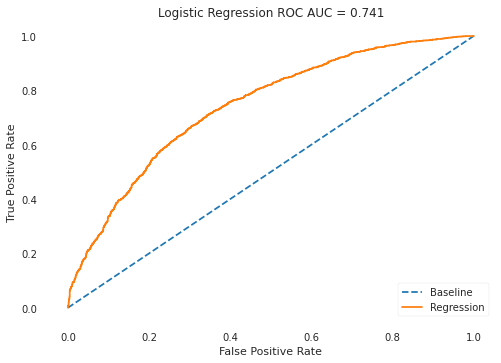

In [92]:
# объединяем данные в новый обучающий датафрейм и повторяем процедуру обучения

df_train2 = pd.concat([other, minor])

X = df_train2.drop(['client_id','default'], axis=1).values
Y = df_train2['default'].values


X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)


model_2 = LogisticRegression()
model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_val)
probs = model_2.predict_proba(X_val)[:,1]

# оценим результаты обучения

metrics_2 = count_metrics(y_val, y_pred, probs)
data_metrics['Undersampling'] = pd.Series(metrics_2)

display(data_metrics)
show_roc_auc(y_val, probs)

Значительно улучшилась метрика F1, и по confusion_matrix заметно, что угадывание дефолтных и недефолтных клиентов теперь происходит куда более равномерно.

Теперь попробуем подобрать гиперпараметры для нашей модели:

In [101]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

X = df_train2.drop(['client_id','default'], axis=1).values
Y = df_train2['default'].values

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

model_3 = LogisticRegression(solver='liblinear')
model_3.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model_3, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 1.0


(в LogisticRegression был выбран solver='liblinear', поскольку вывелась ошибка - solver lbfgs не поддерживает l1 регуляризацию)

Используем рекомендуемые параметры:

,Стандартные настройки,Undersampling,Гиперпараметры
f1,0.041494,0.681213,0.680681
roc_auc,0.742942,0.741379,0.741302
confusion,"[[12872, 61], [1787, 40]]","[[1271, 616], [582, 1280]]","[[1270, 617], [583, 1279]]"


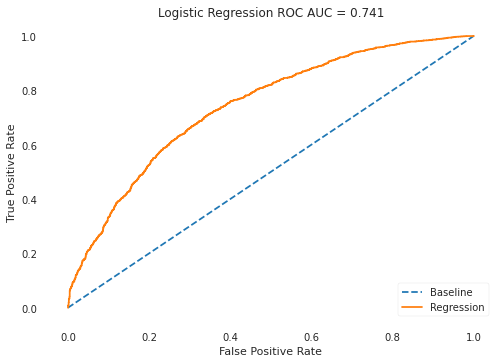

In [100]:
X = df_train2.drop(['client_id','default'], axis=1).values
Y = df_train2['default'].values


X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)


model_4 = LogisticRegression(penalty='l1', C=1,
                             # max_iter=1000,
                             solver = 'liblinear')
model_4.fit(X_train, y_train)

y_pred = model_4.predict(X_val)
probs = model_4.predict_proba(X_val)[:,1]

# оценим результаты обучения

metrics_4 = count_metrics(y_val, y_pred, probs)
data_metrics['Гиперпараметры'] = pd.Series(metrics_4)

display(data_metrics)
show_roc_auc(y_val, probs)

Настройка гиперпараметров привела к довольно незначительному изменению метрик.

## Submission

In [102]:
sample.sample(3)

,client_id,default
11437,64976,0.828294
10803,87874,0.324943
21502,84191,0.405289


In [112]:
# num_cols_std = StandardScaler().fit_transform(data_test[num_cols].values)
X_test = df_test.drop(['client_id','default'], axis=1).values
y_probs = model_4.predict_proba(X_test)[:,1]
df_test['default'] = y_probs

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
submission = df_test[['client_id','default']]
submission.to_csv('submission1.csv', index=False)
submission.sample(3)

,client_id,default
33072,73410,0.418721
31799,54886,0.446181
17304,41602,0.208812
